# 파이썬 머신러닝 완벽 가이드 
- 자전거 대여 수요 예측 (p.342~)

# Libs

In [13]:
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import logging
import numpy as np

import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np

import geopandas as gpd
from shapely import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points
from sklearn.cluster import DBSCAN

from tqdm import tqdm
tqdm.pandas()

# 시각화 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import font_manager as fm, rc

# 한글 폰트 설정
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# Data Import

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Goal
1. Forecasting count
2. Forecasting casual + registerd

In [5]:
display(train.head())
display(test.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# EDA
- Null None

In [6]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [8]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

In [9]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22


# Modeling

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Metrics

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y,pred):
    log_y, log_pred = np.log1p(y), np.log1p(pred)
    rmsle = np.sqrt(np.mean((log_y - log_pred) ** 2))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print(f'RMSLE : {rmsle_val:.3f}\nRMSE : {rmse_val:.3f}\nMAE : {mae_val:.3f}')

## First Modeling
- Only Use Count

In [22]:
fmodel = train.copy()

fmodel.drop(columns=['datetime','casual','registered'],inplace=True)

y_target = fmodel['count']
X_features = fmodel.drop(columns=['count'])

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_model = LinearRegression().fit(X_train,y_train)
lr_model_pred = lr_model.predict(X_test)

evaluate_regr(y_test,lr_model_pred)

RMSLE : 1.165
RMSE : 140.900
MAE : 105.924


In [24]:
def get_top_error_data(y_test, pred, n_tops=5):
    #DataFrame의 컬럼으로 실제 대여횟수(count)와 예측 값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test, lr_model_pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


## 애초에 Y값이 정규분포를 이루고 있지않음

<Axes: >

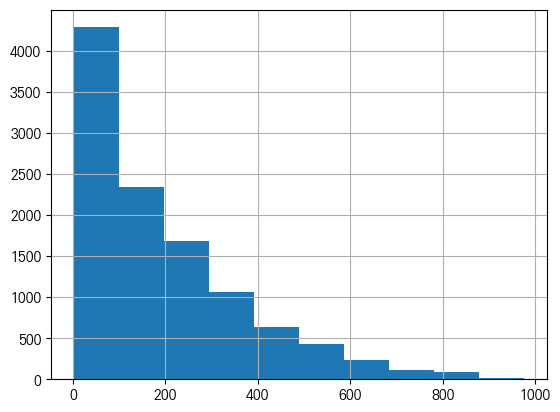

In [25]:
y_target.hist()

### 로그 변환
- 로그 변환 복구 -> np.exmp1() 지수 함수 적용

<Axes: >

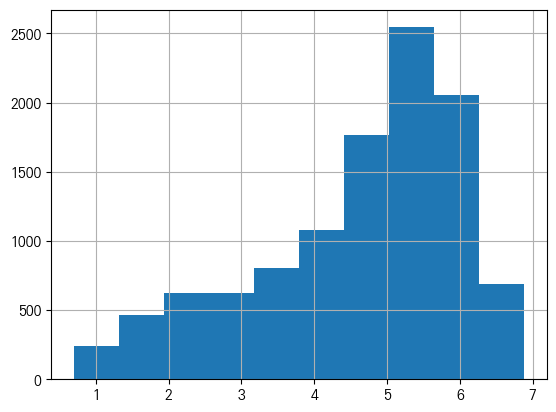

In [27]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [31]:
# 타깃 컬럼 count값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)
# 로그 변환된 y_tay_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_model = LinearRegression().fit(X_train,y_train)
lr_model_pred = lr_model.predict(X_test)

#테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)
# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(lr_model_pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017
RMSE : 162.594
MAE : 109.286


In [33]:
coef

year          0.418513
hour          0.098348
month         0.076839
atemp         0.030857
temp          0.011712
windspeed     0.003961
day           0.003353
humidity     -0.014512
weather      -0.014733
season       -0.044525
holiday      -0.046010
workingday   -0.066383
dtype: float64

<Axes: ylabel='None'>

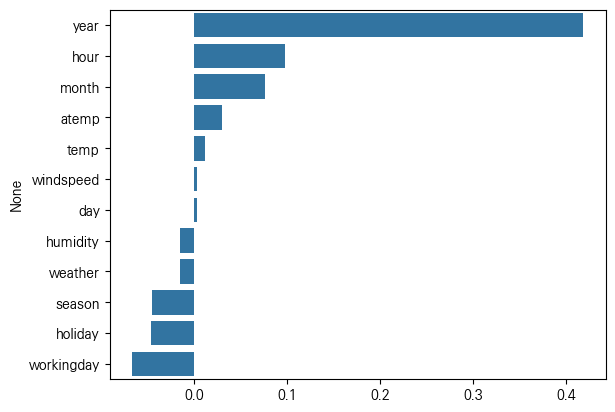

In [38]:
coef = pd.Series(lr_model.coef_, index= X_features.columns).sort_values(ascending=False)
sns.barplot(x=coef.values, y=coef.index)

### 특정 feature가 영향을 크게 주고 있음

In [39]:
X_features_ohe = pd.get_dummies(X_features,columns=['year','month','day','hour','holiday','workingday','season','weather'])

## Featrue 변형 & Y 로그변환

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=42)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('\n''###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)


for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train, y_test, is_expm1=True)


### LinearRegression ###
RMSLE : 0.585
RMSE : 95.845
MAE : 62.352

### Ridge ###
RMSLE : 0.587
RMSE : 96.827
MAE : 62.889

### Lasso ###
RMSLE : 0.639
RMSE : 112.044
MAE : 71.914


<Axes: ylabel='None'>

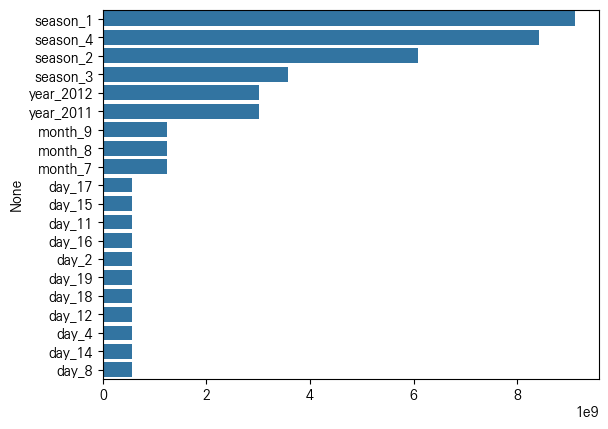

In [47]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns).sort_values(ascending=False)[:20]
sns.barplot(x=coef.values, y=coef.index)

In [50]:
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500,learning_rate=0.01)

for model in [rf_reg,gbm_reg,xgb_reg,lgbm_reg]:
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)


### RandomForestRegressor ###
RMSLE : 0.349
RMSE : 47.880
MAE : 29.926

### GradientBoostingRegressor ###
RMSLE : 0.331
RMSE : 51.718
MAE : 32.214

### XGBRegressor ###
RMSLE : 0.344
RMSE : 52.341
MAE : 32.070
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.585795

### LGBMRegressor ###
RMSLE : 0.364
RMSE : 59.295
MAE : 37.054
